In [1]:
import numpy as np 
import math
import pandas as pd
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
exps_dir = "../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [3]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
x_train

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,auto_year,day_policy_bind_date,month_policy_bind_date,year_policy_bind_date,day_incident_date,month_incident_date,year_incident_date,week_incident_date,high_week,high_hour
0,2,0,0,1,1,-1.770734,0,1,2,11,...,2,0.579574,-0.179439,-1.020460,-1.393943,-0.947412,0,-1.705084,0,0
1,0,2,1,0,2,-1.979562,0,1,4,11,...,0,-0.547936,-0.179439,0.908584,0.115223,0.953085,0,1.136723,0,0
2,2,0,2,0,2,0.675544,0,0,0,5,...,1,1.481582,0.108179,-0.744883,0.115223,-0.947412,0,-0.893139,1,0
3,2,0,0,0,2,-0.492901,0,0,2,2,...,0,1.368831,-0.467057,1.735317,-1.626123,2.853582,0,1.542695,0,0
4,2,0,2,1,1,0.613672,0,1,4,2,...,1,0.128570,0.971032,1.735317,1.160031,-0.947412,0,-0.487167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,2,0,2,0,2,-1.393488,0,0,0,6,...,1,0.908354,0.656524,0.393463,-0.917630,-0.947412,0,-1.409131,0,0
1018,1,0,0,0,0,0.661055,0,0,1,3,...,0,0.839585,-0.592273,1.479683,0.680663,0.953085,0,1.071228,0,0
1019,0,0,1,0,1,-0.077354,5,1,4,3,...,1,-0.883912,-0.196871,-1.006542,-0.093503,0.914690,0,0.706145,1,1
1020,0,0,1,0,0,-0.839075,3,0,5,5,...,1,0.355841,-0.752419,0.704873,0.118865,0.953085,0,0.936124,0,0


In [4]:
from keras.layers import Input, Conv1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D, Dense
from keras.models import Model
import keras.backend as K

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=2):
    """A block that has a conv layer at shortcut."""
    filters1, filters2, filters3 = filters
    bn_axis=1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv1D(filters1, 1, strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv1D(filters3, 1, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv1D(filters3, 1, strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

# The ResNet50 model definition would go here, replacing Conv2D layers with Conv1D
# and adjusting other layers as necessary for one-dimensional data.


In [5]:
from keras.layers import Input, Conv1D, BatchNormalization, Activation, add, MaxPooling1D, GlobalAveragePooling1D,ZeroPadding1D, Dense, Flatten
from keras.models import Model
import keras.backend as K



def ResNet50_1D(input_shape=(42,1), classes=1):
    x_input = Input(shape=input_shape)
    bn_axis = -1

    # First Conv1D layer
    x = ZeroPadding1D(padding=1)(x_input)
    x = Conv1D(64, 7, strides=2, padding='same', name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(3, strides=2)(x)

    # ResNet blocks
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=1)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    # Repeat this pattern as needed

    # Ending layers
    x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid', name='fc')(x)
    #x = Dense(classes, activation='softmax', name='fc1000')(x)

    # Create model
    model = Model(x_input, x, name='resnet50_1d')
    return model

# Create the modified ResNet50 model
model = ResNet50_1D()

# Summary of the model
model.summary()


Model: "resnet50_1d"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42, 1)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 44, 1)       0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 22, 64)       512         ['zero_padding1d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 22, 64)       256         ['conv1[0][0]']                  
                                                                                        

                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 10, 256)     40          ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 10, 256)      0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 10, 256)      0           ['add_2[0][0]']                  
                                                                                                  
 res3a_branch2a (Conv1D)        (None, 5, 128)       32896       ['activation_9[0][0]']           
          

                                                                                                  
 activation_18 (Activation)     (None, 5, 512)       0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv1D)        (None, 5, 128)       65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 5, 128)      20          ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_19 (Activation)     (None, 5, 128)       0           ['bn3d_branch2a[0][0]']          
                                                                                                  
 res3d_bra

 ion)                                                                                             
                                                                                                  
 activation_28 (Activation)     (None, 3, 256)       0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv1D)        (None, 3, 256)       196864      ['activation_28[0][0]']          
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 3, 256)      12          ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_29 (Activation)     (None, 3, 256)       0           ['bn4c_branch2b[0][0]']          
          

 res4f_branch2c (Conv1D)        (None, 3, 1024)      263168      ['activation_38[0][0]']          
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, 3, 1024)     12          ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_12 (Add)                   (None, 3, 1024)      0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 3, 1024)      0           ['add_12[0][0]']                 
                                                                                                  
 res5a_bra

                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 2048)      0           ['add_15[0][0]']                 
                                                                                                  
 global_average_pooling1d (Glob  (None, 2048)        0           ['activation_48[0][0]']          
 alAveragePooling1D)                                                                              
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['global_average_pooling1d[0][0]'
                                                                 ]                                
                                                                                                  
 fc (Dense

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

lr=0.0001
model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics='accuracy')
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix

class ConfusionMatrixCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.relist={}
        self.acc=[]

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred = self.model.predict(X_val)
        y_pred_binary = (y_pred > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred_binary)
        print(f"Confusion Matrix after Epoch {epoch + 1}:\n{cm}")
        print(classification_report(y_test,y_pred_binary))
        acc = float(classification_report(y_test,y_pred_binary).split('\n')[3].split()[2])
        self.acc.append(acc)
        self.relist[acc]=y_pred_binary

# ... Định nghĩa mô hình ...

# Tạo đối tượng callback
confusion_matrix_callback = ConfusionMatrixCallback(validation_data=(x_test,y_test))

callbacks = [early_stopping,lr_scheduler]

checkpointer = ModelCheckpoint(filepath = "Emotion_weights.hdf5", verbose = 1, save_best_only=True)

history=model.fit(x=x_train,y=y_train,
          validation_data=(x_test,y_test),
          batch_size=64,epochs=120, callbacks=[earlystopping,checkpointer])



Epoch 1/120


C:\Users\PC\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - ETA: 0s - loss: 1.4540 - accuracy: 0.5029
Epoch 1: val_loss improved from inf to 0.77828, saving model to Emotion_weights.hdf5
16/16 [==============================] - 22s 635ms/step - loss: 1.4540 - accuracy: 0.5029 - val_loss: 0.7783 - val_accuracy: 0.2667
Epoch 2/120
16/16 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.5910
Epoch 2: val_loss improved from 0.77828 to 0.76607, saving model to Emotion_weights.hdf5
16/16 [==============================] - 8s 477ms/step - loss: 0.6784 - accuracy: 0.5910 - val_loss: 0.7661 - val_accuracy: 0.2667
Epoch 3/120
16/16 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.6575
Epoch 3: val_loss improved from 0.76607 to 0.75842, saving model to Emotion_weights.hdf5
16/16 [==============================] - 8s 524ms/step - loss: 0.6468 - accuracy: 0.6575 - val_loss: 0.7584 - val_accuracy: 0.2667
Epoch 4/120
16/16 [==============================] - ETA: 0s - loss: 0

16/16 [==============================] - 7s 409ms/step - loss: 0.0104 - accuracy: 0.9961 - val_loss: 2.0789 - val_accuracy: 0.7212
Epoch 31/120
16/16 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9990
Epoch 31: val_loss did not improve from 0.75842
16/16 [==============================] - 7s 474ms/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 3.2474 - val_accuracy: 0.5939
Epoch 32/120
16/16 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9873
Epoch 32: val_loss did not improve from 0.75842
16/16 [==============================] - 8s 471ms/step - loss: 0.0368 - accuracy: 0.9873 - val_loss: 2.5775 - val_accuracy: 0.7091
Epoch 33/120
16/16 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9726
Epoch 33: val_loss did not improve from 0.75842
16/16 [==============================] - 8s 481ms/step - loss: 0.0665 - accuracy: 0.9726 - val_loss: 1.5374 - val_accuracy: 0.6818
Epoch 33: early stopping


<Axes: >

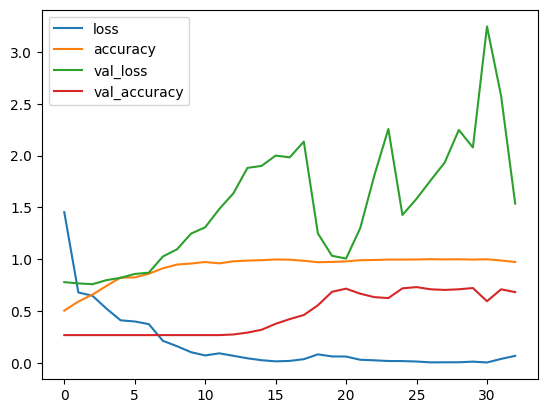

In [7]:
losses = pd.DataFrame(history.history)
losses.plot()

In [8]:
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y_test,y_pred_binary))


11/11 [==============================] - 2s 27ms/step
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       242
           1       0.42      0.52      0.47        88

    accuracy                           0.68       330
   macro avg       0.62      0.63      0.62       330
weighted avg       0.71      0.68      0.69       330

